## Libs Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from geopy.geocoders import Nominatim
import os, re, pycountry, folium, lxml.etree, urllib.request, math, warnings
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')
geolocator = Nominatim(user_agent="openclassroom_project_2")

## Utils

In [2]:
def feature_research(pattern:str, topic:str = None, percentage:bool=True) -> 'feature_list':
    """
    Return a list of indicators codes
    
    Parameters
    ----------
    pattern:str
    Regex pattern to match
    
    topic:str, optional
    Restricts the research to the topics in EdStatsSeries.topic
    
    percentage:bool, default = True
    Restricts the research to the indicators in percentage terms
    """
    feature_list = list()
    for row in EdStatsSeries.iterrows():
        if topic != None and percentage == True:
            if re.search('percentage', row[1]['Long definition'].lower()) \
            and re.search(pattern, row[1]['Long definition'].lower()) \
            and row[1]['Topic'] == topic:
                feature_list.append(row[0])
        elif topic != None and percentage == False:
            if re.search(pattern, row[1]['Long definition'].lower()) \
            and row[1]['Topic'] == topic:
                feature_list.append(row[0])
                
        elif topic == None and percentage == True:
            if re.search('percentage', row[1]['Long definition'].lower()) \
            and re.search(pattern, row[1]['Long definition'].lower()):
                feature_list.append(row[0])
            
        else: # topic == None and percentage == False
            if re.search(pattern, row[1]['Long definition'].lower()):
                feature_list.append(row[0])
    return feature_list

def get_territory_languages():
    """
    Return dict, country:spoken languages
    """
    url = "https://raw.githubusercontent.com/unicode-org/cldr/master/common/supplemental/supplementalData.xml"
    langxml = urllib.request.urlopen(url)
    langtree = lxml.etree.XML(langxml.read())

    territory_languages = {}
    for t in langtree.find('territoryInfo').findall('territory'):
        langs = {}
        for l in t.findall('languagePopulation'):
            langs[l.get('type')] = {
                'percent': float(l.get('populationPercent')),
                'official': bool(l.get('officialStatus'))
            }
        territory_languages[t.get('type')] = langs
    return territory_languages

def iso_code_alpha_3_to_alpha_2(x):
    try:
        return pycountry.countries.get(alpha_3=x).alpha_2
    except:
        return 1
    
def map_language(x):
    try:
        return language_dict[x]
    except:
        return np.NaN
    
def map_isolate_languages(x):
    if x in isolate_languages:
        return 'isolate_language'
    else:
        return x    

## Data imports

In [3]:
filepath = '/Users/leoguillaume/Documents/openclassrooms-projects/openclassrooms-project-2/data/Projet+Python_Dataset_Edstats_csv/'

In [4]:
csv_list = os.listdir(filepath)

In [5]:
for csv in csv_list:
    locals()[csv[:-4]] = pd.read_csv(os.path.join(filepath,csv))

In [6]:
for csv in csv_list:
    print(csv+'\n'+40*'-')
    locals()[csv[:-4]].info()
    print('\n')

EdStatsCountry.csv
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                  

## Tables shapes

In [7]:
print('Row\n' + 30*'-')
for csv in csv_list:
    print(f"{csv}: {str(locals()[csv[:-4]].shape[0])}")
    
print('\nFeatures\n' + 30*'-')
for csv in csv_list:
    print(f"{csv}: {str(locals()[csv[:-4]].shape[1])}")  

Row
------------------------------
EdStatsCountry.csv: 241
EdStatsCountry-Series.csv: 613
EdStatsData.csv: 886930
EdStatsFootNote.csv: 643638
EdStatsSeries.csv: 3665

Features
------------------------------
EdStatsCountry.csv: 32
EdStatsCountry-Series.csv: 4
EdStatsData.csv: 70
EdStatsFootNote.csv: 5
EdStatsSeries.csv: 21


## Tables contents

EdStatsSeries : informations about indicators (descriptions) >> for feature selection

EdStatsCountry : country statistics (use incomes group)

EdStatsCountrySeries : sources of StatSeries >> useless

EdStatsData : country education statistics >> main data

EdStatsFootNote : year of country indicator of EdStatsData are present >> for filtered EdStatsData with % data score

## Datapoints (~ missing values)

In [8]:
print(f"""
Number of countries: {EdStatsData['Country Name'].nunique()}
Number of indicator per country: {EdStatsData['Indicator Code'].nunique()}
""")


Number of countries: 242
Number of indicator per country: 3665



In [9]:
# drop unless columns and sort index to get the years columns first
EdStatsData.drop(columns = 'Unnamed: 69', inplace = True)
EdStatsData.sort_index(axis = 1, inplace = True)

### Per years

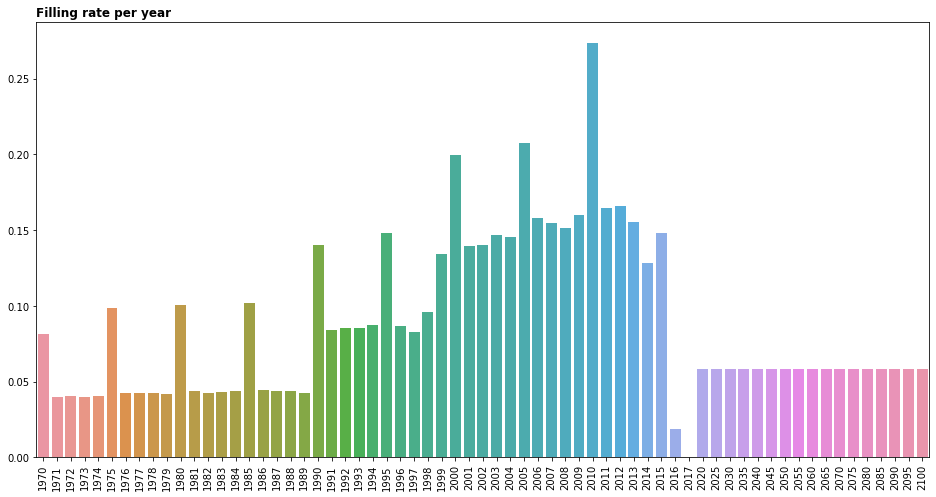

In [10]:
filling_rate_per_years = EdStatsData.iloc[:, :-4].notna().sum(axis = 0) / EdStatsData.shape[0]
plt.figure(figsize = (16, 8))
sns.barplot(x = filling_rate_per_years.index, y = filling_rate_per_years.values)
plt.xticks(rotation = 90)
plt.title('Filling rate per year', fontweight = 'bold', loc = 'left')
plt.show()

> It can be seen that the period 1990 to 2015 is the most complete in terms of data.

In [11]:
EdStatsData[EdStatsData.iloc[:,48:-4].isna().sum(axis = 1) != 17].iloc[:,48:]['Indicator Name'].unique()[:5]

array(['Wittgenstein Projection: Mean years of schooling. Age 0-19. Female',
       'Wittgenstein Projection: Mean years of schooling. Age 0-19. Male',
       'Wittgenstein Projection: Mean years of schooling. Age 0-19. Total',
       'Wittgenstein Projection: Mean years of schooling. Age 15+. Female',
       'Wittgenstein Projection: Mean Years of Schooling. Age 15+. Gender Gap'],
      dtype=object)

> Data after 2020 are projection indicators.

### Per indicators

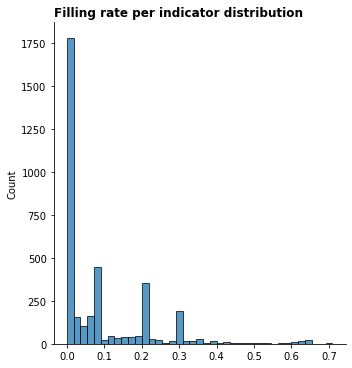

In [12]:
values_per_indicator = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:, :-4].shape[1]
values_per_indicator = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:, :-4].shape[1]
filling_rate_per_indicator = (EdStatsData.iloc[:, :-4].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum().sum(axis = 1) / values_per_indicator).sort_values()
sns.displot(filling_rate_per_indicator)
plt.title('Filling rate per indicator distribution', fontweight = 'bold', loc = 'left')
plt.show()

> Most of the indicators have very little data.

In [13]:
f'% of indicators with more 50% of filled values: {(filling_rate_per_indicator > 0.5).sum() / len(filling_rate_per_indicator):.2%}'

'% of indicators with more 50% of filled values: 1.69%'

### Per country

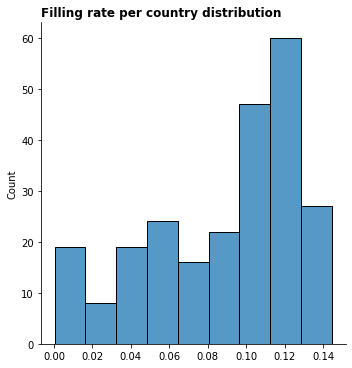

In [14]:
values_per_country = EdStatsData['Country Name'].value_counts()[0] * EdStatsData.iloc[:, :-4].shape[1]
filling_rate_per_country = (EdStatsData.iloc[:, :-4].notna().groupby(EdStatsData['Country Name'], sort = False).sum().sum(axis = 1) / values_per_country).sort_values()
sns.displot(filling_rate_per_country)
plt.title('Filling rate per country distribution', fontweight = 'bold', loc = 'left')
plt.show()

> The filling rate is relatively low (around 12 and 14%).

#### World map of datapoints

In [ ]:
datapoints_map = folium.Map(location=[12,1], zoom_start=2)
geo_dict = dict()
for country, datapoints in filling_rate_per_country.iteritems():
    try:
        geo_dict[country] = {'latitude': geolocator.geocode(country.split(',')[0]).latitude,
                             'longitude': geolocator.geocode(country.split(',')[0]).longitude}

        folium.Circle(location=[geo_dict[country]['latitude'], geo_dict[country]['longitude']],
              popup=country,
              radius= datapoints * 1000000,
              color='crimson',
              fill=True,
              fill_color='crimson').add_to(datapoints_map)
    except Exception as e:                                    
            print(f'Error {e} for {country}')

In [ ]:
datapoints_map

## Duplicates values

In [15]:
EdStatsData_notna = EdStatsData[~EdStatsData.index.isin(EdStatsData.iloc[:,:-4][EdStatsData.iloc[:,:-4].notna().sum(axis =1) == 0].index)]
f"% of duplicates values in EdStatsData: {(len(EdStatsData_notna) - len(EdStatsData_notna.drop(columns = ['Indicator Name', 'Indicator Code']).drop_duplicates())) / len(EdStatsData_notna):.2%}"

'% of duplicates values in EdStatsData: 3.48%'

> Less than 2% of rows measures same things.

## Data cleaning

**Restrict analysis on 2000 to 2015**

In [16]:
for column in EdStatsData.iloc[:,:-4].columns:
    if int(column) > 2015 or int(column) < 2000:
        EdStatsData.drop(columns = column, inplace = True)

> Before 2000 there are too few data and they are too old for the purpose of the analysis. After 2015 there are no data or only projection indicators. 

**Exclude low income country from analysis**

In [17]:
low_income_country_codes = EdStatsCountry[EdStatsCountry['Income Group'] == 'Low income']['Country Code'].values
EdStatsData = EdStatsData[~EdStatsData['Country Code'].isin(low_income_country_codes)]
EdStatsData.reset_index(drop=True, inplace=True)

> Low income country aren't interesting markets

**Keep only country from analysis**

In [18]:
EdStatsData = EdStatsData.iloc[25 * 3665:]

**Keep only country with a population superior than 1M**

In [19]:
population_csv_path = '/Users/leoguillaume/Documents/openclassrooms-projects/openclassrooms-project-2/data/population_csv.csv'
population = pd.read_csv(population_csv_path)
population_2018 = population.drop_duplicates(subset = 'Country Code', keep = 'last')[['Country Code', 'Value']]
EdStatsData = EdStatsData.merge(population_2018, on ='Country Code')
EdStatsData.rename(columns = {'Value':'population'}, inplace = True)

In [20]:
EdStatsData.population.describe()

count    6.706950e+05
mean     3.618742e+07
std      1.477648e+08
min      1.150800e+04
25%      4.846300e+05
50%      4.867309e+06
75%      1.872916e+07
max      1.392730e+09
Name: population, dtype: float64

In [21]:
EdStatsData = EdStatsData.loc[EdStatsData.population > EdStatsData.population.quantile(0.25)]

In [22]:
print(f"""
Number of countries: {EdStatsData['Country Name'].nunique()}
""")


Number of countries: 137



## Feature selection
### Ponctual feature

- education rate in upper secondary school
- education rate in tertiary school
- internet covering

**Metrics to feature selection**

- filling value rate

In [23]:
values_per_indicator_all_years = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:,:16].shape[1]
filling_rate = (EdStatsData.iloc[:,:16].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum().sum(axis = 1) / values_per_indicator_all_years)

In [24]:
EdStatsSeries.set_index('Series Code', inplace = True)

In [25]:
EdStatsSeries['filling_rate'] = filling_rate

- mean of years of most recents datapoints 

In [26]:
df = EdStatsData.iloc[:,:16].transform(lambda x: np.where(x.isnull(), x, x.name))
df.replace({'nan': np.NaN}, inplace = True)
EdStatsData['last_year'] = df.ffill(axis = 1)['2015']

In [27]:
EdStatsSeries['mean_most_recent_years'] = EdStatsData.groupby('Indicator Code').last_year.mean()

**Search: education rate in upper secondary school**

In [28]:
upper_secondary_feature_list = feature_research('upper secondary', topic = 'Secondary', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(upper_secondary_feature_list),
                  ['Long definition', 'mean_most_recent_years', 'filling_rate']
                 ].sort_values(['filling_rate', 'mean_most_recent_years'], ascending = [False, False]).head(5)

,Long definition,mean_most_recent_years,filling_rate
Series Code,,,
UIS.FEP.3.GPV,Number of female general education students at the upper secondary level expressed as a percentage of the total number of general education students (male and female) at the upper secondary level in a given school year.,2013.320896,0.765055
SE.SEC.ENRR.UP,"Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.",2013.830769,0.762774
SE.SEC.ENRR.UP.MA,"Total male enrollment in upper secondary education, regardless of age, expressed as a percentage of the male population of official upper secondary education age.",2013.891473,0.749088
UIS.FEP.3,Number of female students at the upper secondary level expressed as a percentage of the total number of students (male and female) at the upper secondary level in a given school year.,2013.045455,0.721259
UIS.GTVP.3.GPV,"Total number of students enrolled in general programmes at the upper secondary education level, expressed as a percentage of the total number of students enrolled in all programmes (vocational and general) at the upper secondary level. General education is designed to develop learners’ general knowledge, skills and competencies and literacy and numeracy skills, often to prepare students for more advanced educational programmes at the same or higher ISCED levels and to lay the foundation for ...",2012.909091,0.703467


> **SE.SEC.ENRR.UP**: Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.

**Search: education rate in tertiary school**

In [29]:
tertiary_feature_list = feature_research('tertiary', topic = 'Tertiary', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(tertiary_feature_list),
                  ['Long definition', 'mean_most_recent_years', 'filling_rate']
                 ].sort_values(['filling_rate', 'mean_most_recent_years',], ascending = [False, False]).head(5)

,Long definition,mean_most_recent_years,filling_rate
Series Code,,,
UIS.GOER.56,Total number of mobile tertiary students coming from a country/region as a percentage of the population of tertiary student age in their home country.,2012.453846,0.791971
SE.TER.ENRR,"Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving.",2013.300000,0.711679
SE.TER.ENRL.FE.ZS,Number of female students at the tertiary education level (ISCED 5 to 8) expressed as a percentage of the total number of students (male and female) at the tertiary education level (ISCED 5 to 8) in a given school year.,2013.406015,0.708485
SE.TER.ENRR.FE,"Total female enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total female population of the five-year age group following on from secondary school leaving.",2013.325581,0.688412
SE.TER.ENRR.MA,"Total male enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total male population of the five-year age group following on from secondary school leaving.",2013.325581,0.688412


> **SE.TER.ENRR**: Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving.

**Search: internet covering**

In [30]:
EdStatsSeries.loc[EdStatsSeries.Topic == 'Infrastructure: Communications', 
                  ['Indicator Name', 'Long definition', 'filling_rate', 'mean_most_recent_years']
                 ]

,Indicator Name,Long definition,filling_rate,mean_most_recent_years
Series Code,,,,
IT.CMP.PCMP.P2,Personal computers (per 100 people),Personal computers are self-contained computers designed to be used by a single individual.,0.405566,2006.007576
IT.NET.USER.P2,Internet users (per 100 people),"Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.",0.969434,2015.000000


> **IT.NET.USER.P2**: Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.

### Temporal indicators

- upper secondary school growth
- tertiary school growth
- primary school growth
- education expenditure growth

**Metric to feature selection**

- filling rate

> **SE.SEC.ENRR.UP**: Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.<br>
**SE.TER.ENRR**: Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving.

**Search: primary school**

In [31]:
primary_feature_list = feature_research('primary', topic = 'Primary', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(primary_feature_list),
                  ['Long definition', 'mean_most_recent_years', 'filling_rate']
                 ].sort_values(['filling_rate', 'mean_most_recent_years',], ascending = [False, False]).head(5)

,Long definition,mean_most_recent_years,filling_rate
Series Code,,,
SE.PRM.ENRL.FE.ZS,Number of female students at the primary level expressed as a percentage of the total number of students (male and female) at the primary level in a given school year.,2014.345588,0.870894
SE.PRM.ENRR,"Total enrollment in primary education, regardless of age, expressed as a percentage of the population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.",2014.240602,0.849909
SE.PRM.ENRR.FE,"Total female enrollment in primary education, regardless of age, expressed as a percentage of the female population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.",2014.240602,0.846715
SE.PRM.ENRR.MA,"Total male enrollment in primary education, regardless of age, expressed as a percentage of the male population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.",2014.240602,0.846715
SE.PRM.PRIV.ZS,"Total number of students in primary education enrolled in institutions that are not operated by a public authority but controlled and managed, whether for profit or not, by a private body (e.g., non-governmental organisation, religious body, special interest group, foundation or business enterprise), expressed as a percentage of total number of students enrolled in primary education.",2014.369231,0.756843


> **SE.PRM.ENRR**: Total enrollment in primary education, regardless of age, expressed as a percentage of the population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.

**Search: education expenditure**

In [32]:
expenditure_feature_list = feature_research('education', topic = 'Expenditures', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(expenditure_feature_list),
                  ['Long definition', 'filling_rate']
                 ].sort_values(['filling_rate'], ascending = False).head(5)

,Long definition,filling_rate
Series Code,,
SE.XPD.TOTL.GD.ZS,"Total general (local, regional and central) government expenditure on education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. Divide total government expenditure for a given level of education (ex. primary, secondary, or all levels combined) by the GDP, and multiply by 100. A higher percentage of GDP spent on education shows a higher government priority for education, but also a highe...",0.604471
SE.XPD.TOTL.GB.ZS,"Total general (local, regional and central) government expenditure on education (current, capital, and transfers), expressed as a percentage of total general government expenditure on all sectors (including health, education, social services, etc.). It includes expenditure funded by transfers from international sources to government. Public education expenditure includes spending by local/municipal, regional and national governments (excluding household contributions) on educational institut...",0.586223
SE.XPD.TERT.ZS,"Expenditure on education by level of education, expressed as a percentage of total general government expenditure on education. Divide government expenditure on a given level of education (ex. primary, secondary) by total government expenditure on education (all levels combined), and multiply by 100. A high percentage of government expenditure on education spent on a given level denotes a high priority given to that level compared to others. When interpreting this indicator, one should take ...",0.496350
SE.XPD.PRIM.PC.ZS,"Average total (current, capital and transfers) general government expenditure per student in the given level of education, expressed as a percentage of GDP per capita. Divide total government expenditure for a given level of education (ex. primary, secondary) by total enrolment in that same level, divide again by GDP per capita, and multiply by 100. For more information, consult the UNESCO Institute of Statistics website: http://www.uis.unesco.org/Education/",0.457117
UIS.XGDP.56.FSGOV,"Total general (local, regional and central) government expenditure on tertiary education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. Divide total government expenditure for a given level of education (ex. primary, secondary, or all levels combined) by the GDP, and multiply by 100. For more information, consult the UNESCO Institute of Statistics website: http://www.uis.unesco.org/Edu...",0.450730


> **SE.XPD.TOTL.GD.ZS**: Total general (local, regional and central) government expenditure on education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. 

## Features analysis

In [33]:
ponctual_indicators = ['SE.SEC.ENRR.UP', 'SE.TER.ENRR', 'IT.NET.USER.P2']
temporal_indicators = ['SE.SEC.ENRR.UP', 'SE.TER.ENRR', 'SE.PRM.ENRR', 'SE.XPD.TOTL.GD.ZS']

### Cluster definition

- per regions
- per language
- per country

**Regions list**

In [34]:
EdStatsData = EdStatsData.merge(EdStatsCountry[['Region', 'Country Code', 'Income Group']], on ='Country Code')
regions_list = EdStatsData.Region.unique()[pd.notnull(EdStatsData.Region.unique())]

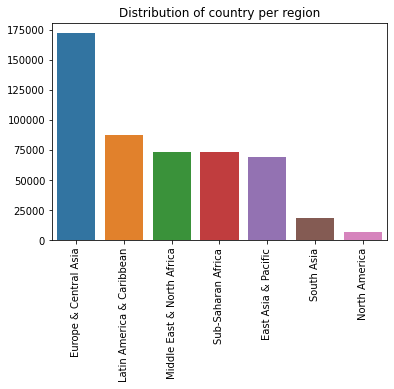

In [35]:
plt.title('Distribution of country per region')
sns.barplot(x = EdStatsData['Region'].value_counts().index, y = EdStatsData['Region'].value_counts().values)
plt.xticks(rotation = 90)
plt.show()

**Languages list**

In [36]:
EdStatsData['iso_code_alpha2'] = EdStatsData['Country Code'].apply(iso_code_alpha_3_to_alpha_2)
territory_languages = get_territory_languages()
language_dict = dict()
for name, iso_3, iso_2 in tuple(EdStatsCountry[['Short Name', 'Country Code', 'WB-2 code']].values): 
    try:
        language_dict[iso_3] =  list(territory_languages[iso_2].keys())[0]
    except:
        print(f'Error with {name}, code: {iso_2}')

Error with Arab World, code: 1A
Error with Channel Islands, code: JG
Error with Dem. Rep. Congo, code: ZR
Error with East Asia & Pacific (developing only), code: 4E
Error with East Asia & Pacific (all income levels), code: Z4
Error with Europe & Central Asia (developing only), code: 7E
Error with Europe & Central Asia (all income levels), code: Z7
Error with Euro area, code: XC
Error with European Union, code: EU
Error with High income, code: XD
Error with Heavily indebted poor countries (HIPC), code: XE
Error with Latin America & Caribbean (developing only), code: XJ
Error with Latin America & Caribbean (all income levels), code: ZJ
Error with Least developed countries: UN classification, code: XL
Error with Low income, code: XM
Error with Lower middle income, code: XN
Error with Low & middle income, code: XO
Error with Middle East & North Africa (all income levels), code: ZQ
Error with Middle income, code: XP
Error with Middle East & North Africa (developing only), code: XQ
Error wit

In [37]:
EdStatsData['language'] = EdStatsData['Country Code'].apply(map_language)
isolate_languages = EdStatsData.language.value_counts()[EdStatsData.language.value_counts() == 3665].index
EdStatsData['language_2'] = EdStatsData['language'].apply(map_isolate_languages)

In [44]:
EdStatsData['language'].nunique()

67

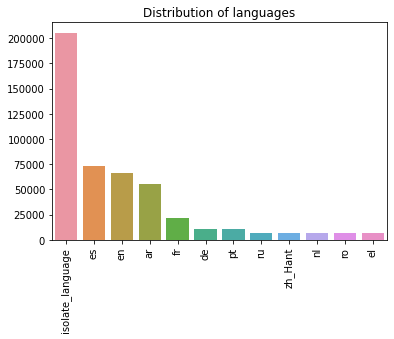

In [38]:
plt.title('Distribution of languages')
sns.barplot(x = EdStatsData['language_2'].value_counts().index, y = EdStatsData['language_2'].value_counts().values)
plt.xticks(rotation = 90)
plt.show()

### Ponctual features

In [39]:
last_values = EdStatsData.iloc[:,:16].ffill(axis = 1)['2015']
EdStatsData['last_value'] = last_values

#### Per regions

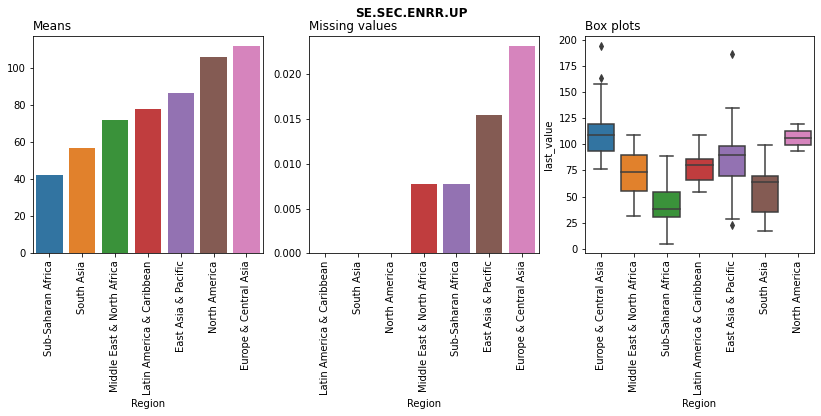

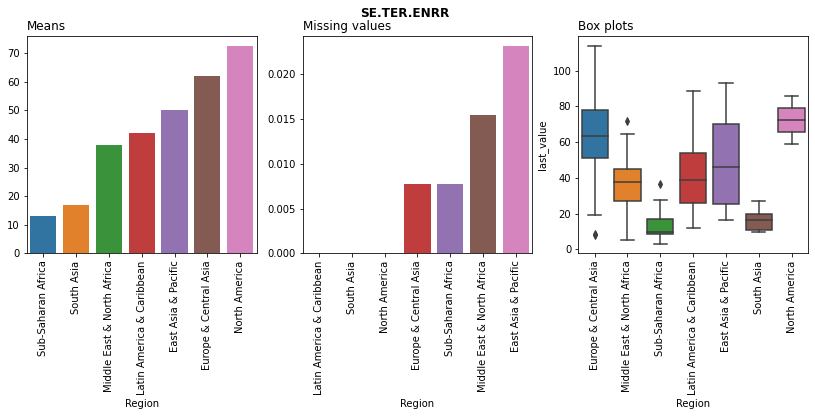

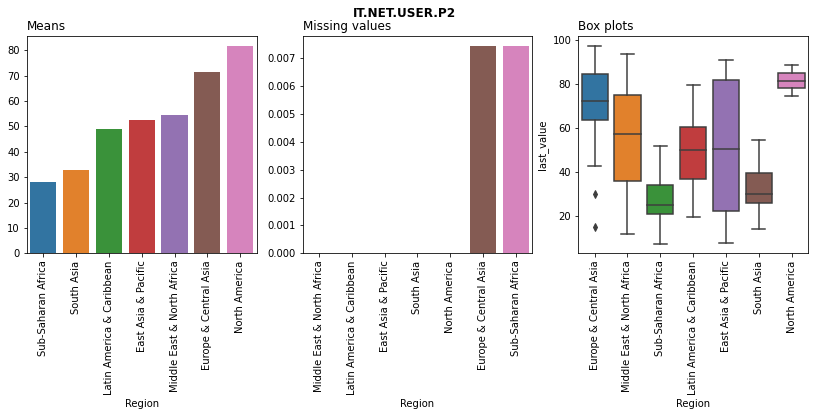

In [40]:
for indicator in ponctual_indicators:
    
    plt.figure(figsize = (14, 4))
    plt.suptitle(t = f"{indicator}", weight = 'bold')
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == indicator, ['Country Name', 'last_value', 'Region']]
    
    plt.subplot(1, 3, 1)
    plt.title(label= 'Means', loc = 'left')
    df_mean = df.groupby('Region').last_value.mean().sort_values()
    sns.barplot(x = df_mean.index, y = df_mean.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 2)
    plt.title(label= 'Missing values', loc = 'left')
    df_missing = (df.set_index('Region').last_value.isna().sum(level=0) / df.set_index('Region').last_value.count()).sort_values()
    sns.barplot(x = df_missing.index, y = df_missing.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 3)
    plt.title(label= 'Box plots', loc = 'left')
    sns.boxplot(x='Region', y= 'last_value', data=df)
    plt.xticks(rotation = 90)
    plt.show()

In [41]:
selected_country_name = list()
selected_country_x = list()
selected_country_y = list()
for region in regions_list:
    country = np.random.choice(EdStatsData.loc[(EdStatsData['Region'] == region)  & (EdStatsData.last_value.notna()), 
                                                'Country Name'].unique(), 2)
    x = EdStatsData.loc[(EdStatsData['Indicator Code'] == ponctual_features[0]) &
                (EdStatsData['Country Name'].isin(country)),
                 'last_value'].values
    y = EdStatsData.loc[(EdStatsData['Indicator Code'] == ponctual_features[1]) & 
                (EdStatsData['Country Name'].isin(country)),
                 'last_value'].values    
    selected_country_name += country.tolist()
    selected_country_x += x.tolist()
    selected_country_y += y.tolist()
    
x = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values
y = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values
hue = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'Region'].values

plt.figure(figsize = (16, 12))
sns.scatterplot(x=x, y=y, hue=hue, alpha = 0.7)
plt.xlabel(f"{ponctual_features[0]}")
plt.ylabel(f"{ponctual_features[1]}")
for x, y, country in zip(selected_country_x, selected_country_y, selected_country_name):
    plt.text(x = x + 0.5, y = y + 1, s = country, weight = 'bold')

NameError: name 'ponctual_features' is not defined

#### Per languages

In [ ]:
for feature in ponctual_features:
    
    plt.figure(figsize = (14, 4))
    plt.suptitle(t = f"{feature}", weight = 'bold')
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == feature, ['Country Name', 'last_value', 'language_2']]
    
    plt.subplot(1, 3, 1)
    plt.title(label= 'Means', loc = 'left')
    df_mean = df.groupby('language_2').last_value.mean().sort_values()
    sns.barplot(x = df_mean.index, y = df_mean.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 2)
    plt.title(label= 'Missing values', loc = 'left')
    df_missing = (df.set_index('language_2').last_value.isna().sum(level=0) / df.set_index('language_2').last_value.count()).sort_values()
    sns.barplot(x = df_missing.index, y = df_missing.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 3)
    plt.title(label= 'Box plots', loc = 'left')
    sns.boxplot(x='language_2', y= 'last_value', data=df)
    plt.xticks(rotation = 90)
    plt.show()

In [ ]:
languages_list = EdStatsData.language_2.unique()[pd.notnull(EdStatsData.language_2.unique())]

In [ ]:
selected_country_name = list()
selected_country_x = list()
selected_country_y = list()
for language in languages_list:
    country = np.random.choice(EdStatsData.loc[(EdStatsData['language_2'] == language)  & (EdStatsData.last_value.notna()), 
                                                'Country Name'].unique(), 1)
    x = EdStatsData.loc[(EdStatsData['Indicator Code'] == ponctual_features[0]) &
                (EdStatsData['Country Name'].isin(country)),
                 'last_value'].values
    y = EdStatsData.loc[(EdStatsData['Indicator Code'] == ponctual_features[1]) & 
                (EdStatsData['Country Name'].isin(country)),
                 'last_value'].values    
    selected_country_name += country.tolist()
    selected_country_x += x.tolist()
    selected_country_y += y.tolist()
    
x = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values
y = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values
hue = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'language_2'].values

plt.figure(figsize = (16, 12))
sns.scatterplot(x=x, y=y, hue=hue, alpha = 0.7)
plt.xlabel(f"{ponctual_features[0]}")
plt.ylabel(f"{ponctual_features[1]}")
for x, y, country in zip(selected_country_x, selected_country_y, selected_country_name):
    plt.text(x = x + 0.5, y = y + 1, s = country, weight = 'bold')

### Temporal features

In [ ]:
EdStatsData['filling_rate'] = EdStatsData.iloc[:,:16].notna().sum(axis = 1) / 26

#### Per regions

In [ ]:
plt.figure(figsize = (12, len(temporal_features) * 6))
for i, feature in enumerate(temporal_features):
    plt.subplot(len(temporal_features), 1, i+1)
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == feature].groupby('Region').mean().iloc[:, :16].transpose()
    sns.lineplot(data = df)
    plt.xticks(rotation = 80)
    plt.title(label = feature, loc = 'left', weight = 'bold')
plt.show()

#### Per languages

In [ ]:
selected_languages = EdStatsData.language_2.value_counts(normalize=True)[:6].index

In [ ]:
plt.figure(figsize = (12, len(temporal_features) * 6))
for i, feature in enumerate(temporal_features):
    plt.subplot(len(temporal_features), 1, i+1)
    df = EdStatsData.loc[(EdStatsData['Indicator Code'] == feature) &
                         (EdStatsData['language_2'].isin(selected_languages))].groupby('language_2').mean().iloc[:, :16].transpose()
    sns.lineplot(data = df)
    plt.xticks(rotation = 80)
    plt.title(label = feature, loc = 'left', weight = 'bold')
plt.show()

## Scoring

**Define scoring metric**

- Ponctual features : $\sum{\text{most recent value}\times weight}$


- Temporal features : $\sum{\frac{\text{lost recent value} - \text{less recent value}}{\text{number of years}}\times weight}$


- Score: ponctual scores + temporal scores

**Weights**

Ponctual : 

- SE.SEC.ENRR.UP > 0.3
- SE.TER.ENRR > 0.3
- IT.NET.USER.P2 > 0.4

Temporal : 

- SE.SEC.ENRR.UP > 0.3
- SE.TER.ENRR > 0.3
- SE.PRM.ENRR > 0.3
- SE.XPD.TOTL.GD.ZS > 0.1

In [ ]:
ponctual_weights = [0.3, 0.3, 0.1]
temporal_weights = [0.3, 0.3, 0.3, 0.1]

In [ ]:
ponctual_scores = pd.Series(np.zeros(EdStatsData['Country Name'].nunique()))
for indicator, weight in zip(ponctual_indicators, temporal_weights):
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == indicator]
    ponctual_scores += (df.last_value * weight).reset_index(drop = True)

In [ ]:
ponctual_scores.index = EdStatsData['Country Name'].unique()

In [ ]:
df = EdStatsData.iloc[:,:16].transform(lambda x: np.where(x.isnull(), x, x.name))
df.replace('nan', np.NaN, inplace = True)
EdStatsData['first_year'] = df.bfill(axis = 1)['2000']
EdStatsData.first_year.fillna(-1, inplace = True)
EdStatsData.first_year = EdStatsData.first_year.astype(int)
EdStatsData.first_year.replace(-1, np.NaN, inplace = True)

In [ ]:
temporal_scores = pd.Series(np.zeros(EdStatsData['Country Name'].nunique()))
for indicator, weight in zip(temporal_indicators, temporal_weights):
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == indicator]
    temporal_scores += (((df.last_value - df.first_value) / (df.last_year - df.first_year)) * weight).reset_index(drop = True)

In [ ]:
temporal_scores.index = EdStatsData['Country Name'].unique()

In [ ]:
scores = ponctual_scores + temporal_scores

In [ ]:
sns.distplot(scores)

### Score analysis

### Per regions

In [ ]:
plt.figure(figsize = (25, 20))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle(t= 'Top 10 score per region', weight = 'bold')
for i, region in enumerate(regions_list):
    plt.subplot(3, 3, i+1)
    plt.title(f"{region}", loc = 'left')
    s = scores[EdStatsData.loc[EdStatsData.Region == region, 'Country Name'].unique()].sort_values().dropna().iloc[-10:]
    sns.barplot(x = s.index, y = s.values)
    plt.xticks(rotation = 80)
plt.show()

### Per languages

In [ ]:
plt.figure(figsize = (25, 20))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle(t= 'Top 10 score per language', weight = 'bold')

for i, language in enumerate(selected_languages):
    plt.subplot(3, 3, i+1)
    plt.title(f"{language}", loc = 'left', weight = 'bold')
    s = scores[EdStatsData.loc[EdStatsData.language_2 == language, 'Country Name'].unique()].sort_values().dropna().iloc[-10:]
    sns.barplot(x = s.index, y = s.values)
    plt.xticks(rotation = 80)
plt.show()

In [ ]:
temporal_scores[EdStatsData.loc[EdStatsData.language == 'en', 'Country Name'].unique()].sort_values(ascending = False)

Ireland, Philippines, New Zealand